# Mask processing for Deep Photo Style Transfer

Process masks generated in Photoshop in order to use them in Deep Photo Style Transfer

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# style_image_path = './examples/Manchester_low_res/photo-1515106426117-7483c8b91e9b_lowres.jpeg'
# content_image_path = './examples/Manchester_low_res/IMG_6707_lowres.png'

In [3]:
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image

import matplotlib.pyplot as plt

import argparse

# ------custom module----
import config
import utils

sys.path.append('seg')
from seg.segmentation import *
from model import *
from merge_index import *

* Compute Laplacian matrix of content image

* Investigate masks generated for both images

In [9]:
import csv
with open('./objectInfo150.csv', 'r') as f:
    reader = csv.reader(f, delimiter=',')
    # get header from first row
    headers = next(reader)
    # get all the rows as a list
    class_data = list(reader)
    # transform data into numpy array
    class_data = np.array(class_data)

In [10]:
class_data = np.array(class_data)
class_data[0, 5]

'wallo'

In [11]:
style_masks_found = []
for i in range(150):
    temp = style_mask_origin[i, :, :].numpy()
    if i not in del_classed and np.sum(temp):
        print(i, np.sum(temp), class_data[i, 5])
        style_masks_found.append(i)
print(style_masks_found)

NameError: name 'style_mask_origin' is not defined

In [ ]:
content_masks_found = []
for i in range(150):
    temp = content_mask_origin[i, :, :].numpy()
    if i not in del_classed and np.sum(temp):
        print(i, np.sum(temp), class_data[i, 5])
        content_masks_found.append(i)
print(content_masks_found)

Save out generated masks for style and content

In [ ]:
merged_style_mask = np.zeros((117, height_, width_), dtype='int')
# merged_content_mask = np.zeros((117, height2, width2), dtype='int')
print()
count = 0
classes = []
for i in range(150):
    temp = style_mask_origin[i, :, :].numpy()
    if i not in del_classed and np.sum(temp)>50:
        #classes.append(count)
        classes.append(i)
        print('i={} found in style mask, sum={}, name={}'.format(i, np.sum(temp), class_data[i, 5]))
        merged_style_mask[count, :, :] = temp
#        merged_content_mask[count, :, :] = content_mask_origin[i, :, :].numpy()
        count += 1
    else:
        if i in content_masks_found:
            print('{} / {} found in content masks'.format(i, class_data[i, 5]))
            classes.append(i)
            merged_style_mask[count, :, :] = np.zeros((height_, width_))
            count += 1
print('Total semantic classes in style image: {}'.format(count))
style_mask_tensor = torch.from_numpy(merged_style_mask[:count, :, :]).float().to(config.device0)
# content_mask_tensor = torch.from_numpy(merged_content_mask[:count, :, :]).float().to(config.device0)
print('Classes found in style: {}'.format(classes))
print(count, merged_style_mask.shape)

* Now remove the unwanted classes (from del_classes) and those with less than 50 pixels!

In [5]:
# merged_style_mask = np.zeros((117, height_, width_), dtype='int')
merged_content_mask = np.zeros((117, height2, width2), dtype='int')
print()
count = 0
classes = []
for i in range(150):
    temp = content_mask_origin[i, :, :].numpy()
    if i not in del_classed and np.sum(temp)>50:
        #classes.append(count)
        classes.append(i)
        print('i={} found in content mask, sum={}, name={}'.format(i, np.sum(temp), class_data[i, 5]))
#         merged_style_mask[count, :, :] = temp
        merged_content_mask[count, :, :] = content_mask_origin[i, :, :].numpy()
        count += 1
    else:
        if i in style_masks_found:
            print('{} / {} found in style masks'.format(i, class_data[i, 5]))
            classes.append(i)
            merged_content_mask[count, :, :] = np.zeros((height2, width2))
            count += 1
print('Total semantic classes in content image: {}'.format(count))
# style_mask_tensor = torch.from_numpy(merged_style_mask[:count, :, :]).float().to(config.device0)
content_mask_tensor = torch.from_numpy(merged_content_mask[:count, :, :]).float().to(config.device0)
print('Classes found in content: {}'.format(classes))
print(count, merged_content_mask.shape)

NameError: name 'height2' is not defined

Save each mask as an image for debugging
content_img size:  torch.Size([1, 3, 700, 525])


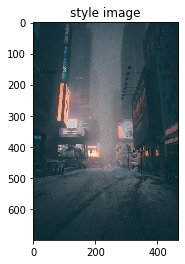

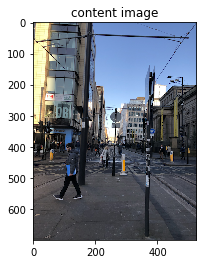

In [86]:
#--------------------------

#--------------------------
print('Save each mask as an image for debugging')
for i in range(count):
    utils.save_pic( torch.stack([style_mask_tensor[i, :, :], style_mask_tensor[i, :, :], style_mask_tensor[i, :, :]], dim=0), 
                                'style_mask_' + str(i) )
    utils.save_pic( torch.stack([content_mask_tensor[i, :, :], content_mask_tensor[i, :, :], content_mask_tensor[i, :, :]], dim=0), 
                                'content_mask_' + str(i) )

# Using GPU or CPU
device = torch.device(config.device0)

style_img = utils.load_image(style_image_path, None)
content_img = utils.load_image(content_image_path, None)
width_s, height_s = style_img.size
width_c, height_c = content_img.size

# print(height_s, width_s)
# print(height_c, width_c)

style_img = utils.image_to_tensor(style_img).unsqueeze(0)
content_img = utils.image_to_tensor(content_img).unsqueeze(0)

style_img = style_img.to(device, torch.float)
content_img = content_img.to(device, torch.float)

print('content_img size: ', content_img.size())
utils.show_pic(style_img, 'style image')
utils.show_pic(content_img, 'content image')




### Convert masks from RGBA to A (Photoshop saves the mask in the "A" column!)

In [112]:
import os
import glob
new_mask_paths = []
mask_paths = glob.glob('./examples/Manchester_low_res/*lowres*mask*.png')
for filepath in mask_paths :
    filename = os.path.basename(filepath)
    dirname = os.path.dirname(filepath)
    img = np.asarray(Image.open(filepath))
    print(filename, img.shape)
    if img.shape[2] == 4:
        img_op = Image.fromarray(img[:, :, 3])
        new_filename = os.path.join(dirname, 'new_{}'.format(filename))
        new_mask_paths.append(new_filename)                                   
        img_op.save(new_filename)
    else:
        print('Can\'t get mask from image {} with shape {}'.format(filename, img.shape))
        img_op = img


photo-1515106426117-7483c8b91e9b_lowres_ground_mask_2.png (700, 467, 4)
IMG_6707_lowres_building_mask_0.png (700, 525, 4)
photo-1515106426117-7483c8b91e9b_lowres_building_mask_0.png (700, 467, 4)
photo-1515106426117-7483c8b91e9b_lowres_sky_mask_1.png (700, 467, 4)
IMG_6707_lowres_ground_mask_2.png (700, 525, 4)
IMG_6707_lowres_sky_mask_1.png (700, 525, 4)


* View masks

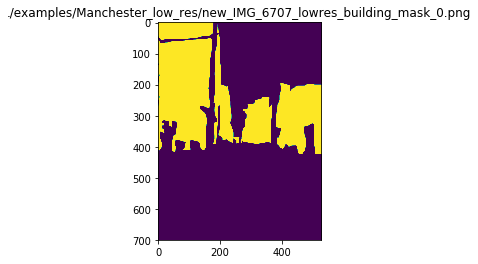

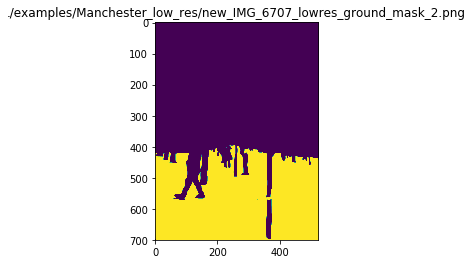

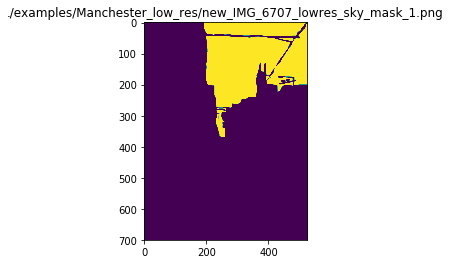

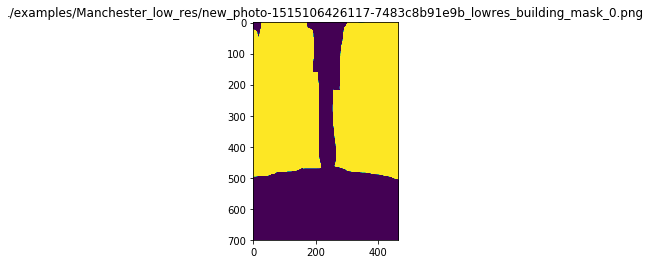

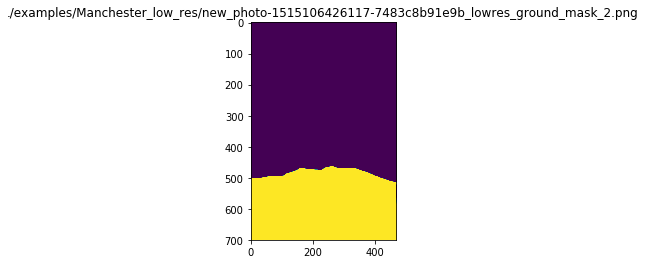

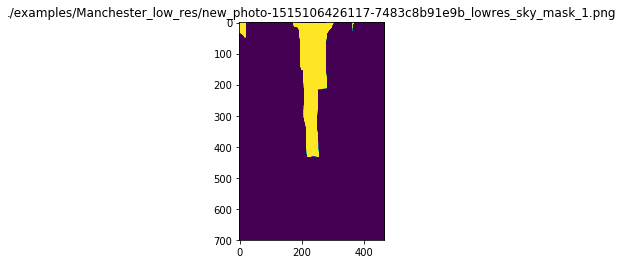

In [113]:
for mask_file in sorted(new_mask_paths):
    # print('mask = {}'.format(mask_file))
    mask = Image.open(mask_file)
    mask_np = np.asarray(mask)
    # print(mask_np[0])
    plt.figure()
    plt.imshow(mask_np)
    plt.title(mask_file)


* Details of an individual mask (if needed!)

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0 190 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 247   5   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

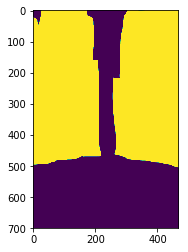

In [116]:
m = Image.open('./examples/Manchester_low_res/new_photo-1515106426117-7483c8b91e9b_lowres_building_mask_0.png') #.convert('L')
# t = utils.image_to_tensor(m)
m = np.asarray(m)
# print(m2.shape)
# # for i in range(len(m2)):
# #     print(m2[i])
# # print(np.asarray(m)[0])
# # utils.show_pic(t)
# mo = m2[:, :, 3]
# print(mo.shape)
print(m[0]) #(m2.T[3][0])
plt.imshow(m)

* Split masks between style and content (useful to copy into DPST code!)

In [122]:
new_style_masks = [
    './examples/Manchester_low_res/new_photo-1515106426117-7483c8b91e9b_lowres_building_mask_0.png',
    './examples/Manchester_low_res/new_photo-1515106426117-7483c8b91e9b_lowres_sky_mask_1.png'
    './examples/Manchester_low_res/new_photo-1515106426117-7483c8b91e9b_lowres_ground_mask_2.png' 
]

new_content_masks = [
    './examples/Manchester_low_res/new_IMG_6707_lowres_building_mask_0.png',
    './examples/Manchester_low_res/new_IMG_6707_lowres_sky_mask_1.png',
    './examples/Manchester_low_res/new_IMG_6707_lowres_ground_mask_2.png'
]


['./examples/Manchester_low_res/new_photo-1515106426117-7483c8b91e9b_lowres_building_mask_0.png', './examples/Manchester_low_res/new_photo-1515106426117-7483c8b91e9b_lowres_sky_mask_1.png./examples/Manchester_low_res/new_photo-1515106426117-7483c8b91e9b_lowres_ground_mask_2.png']
['./examples/Manchester_low_res/new_IMG_6707_lowres_building_mask_0.png', './examples/Manchester_low_res/new_IMG_6707_lowres_sky_mask_1.png', './examples/Manchester_low_res/new_IMG_6707_lowres_ground_mask_2.png']
